In [15]:
from imblearn.over_sampling import SMOTE
import pandas as pd

def load_fold_data(sf, nfs):
    """
    Memuat data lipatan (fold) yang ditentukan untuk prediksi stroke.
    Args:
        SF (int): Indeks lipatan yang akan dimuat dari data stroke.
        NFS (int): Indeks lipatan yang akan dimuat dari data non-stroke.
    Returns:
        tuple: Mengembalikan dua elemen:
            - training_data: Data training yang akan digunakan untuk melatih model.
            - testing_data: Data testing yang akan digunakan untuk menguji model.
    """
    # Load fold dari stroke data
    stroke_fold = pd.read_csv(f'StrokeFold/stroke_fold_{sf}.csv')
    remaining_stroke = [pd.read_csv(f'StrokeFold/stroke_fold_{i}.csv') for i in range(1, 6) if i != sf]
    remaining_stroke = pd.concat(remaining_stroke)

    # Load fold dari no stroke data
    no_stroke_fold = pd.read_csv(f'NonStrokeFold/no_stroke_fold_{nfs}.csv')

    # Ambil 100 data di no_stroke_fold sebagai testing
    testing_no_stroke = no_stroke_fold.sample(n=100, random_state=42)

    # Sisanya sebagai training
    training_no_stroke = no_stroke_fold.drop(testing_no_stroke.index)

    # Gabungkan data training stroke dan non-stroke
    training_data = pd.concat([remaining_stroke, training_no_stroke])

    # Gabungkan data testing stroke dan non-stroke
    testing_data = pd.concat([stroke_fold, testing_no_stroke])
    
    # Inisialisasi SMOTE
    smote = SMOTE(sampling_strategy=0.7, random_state=42)
    
    # Terapkan SMOTE pada data training
    X_train_smote, y_train_smote = smote.fit_resample(training_data.drop(columns=['stroke']), training_data['stroke'])

    # Gabungkan kembali data yang telah di-resample
    training_data = pd.concat([X_train_smote, y_train_smote], axis=1)

    return training_data, testing_data


In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

results = []

# Loop through all combinations of folds
for sf in range(1, 6):
    for nfs in range(1, 6):
        test_data, train_data = load_fold_data(sf, nfs)
        
        # Pisahkan fitur dan target untuk data train dan test
        X_train = train_data.drop(columns=['stroke'])
        y_train = train_data['stroke']
        X_test = test_data.drop(columns=['stroke'])
        y_test = test_data['stroke']
        
        # Inisialisasi model SVM
        svm_model = SVC(kernel='linear', random_state=42)
        
        # Latih model
        svm_model.fit(X_train, y_train)
        
        # Prediksi pada data test
        y_pred = svm_model.predict(X_test)
        
        # Evaluasi model
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Simpan hasil
        results.append({
            'Stroke Fold': sf,
            'Non-Stroke Fold': nfs,
            'Accuracy': accuracy,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        })
        print(f'Fold {sf} vs Fold {nfs} done.')

# Buat DataFrame dari hasil
results_df = pd.DataFrame(results)

# Tampilkan hasil
print(results_df)

Fold 1 vs Fold 1 done.
Fold 1 vs Fold 2 done.
Fold 1 vs Fold 3 done.
Fold 1 vs Fold 4 done.
Fold 1 vs Fold 5 done.
Fold 2 vs Fold 1 done.
Fold 2 vs Fold 2 done.
Fold 2 vs Fold 3 done.
Fold 2 vs Fold 4 done.
Fold 2 vs Fold 5 done.
Fold 3 vs Fold 1 done.
Fold 3 vs Fold 2 done.
Fold 3 vs Fold 3 done.
Fold 3 vs Fold 4 done.
Fold 3 vs Fold 5 done.
Fold 4 vs Fold 1 done.
Fold 4 vs Fold 2 done.
Fold 4 vs Fold 3 done.
Fold 4 vs Fold 4 done.
Fold 4 vs Fold 5 done.
Fold 5 vs Fold 1 done.
Fold 5 vs Fold 2 done.
Fold 5 vs Fold 3 done.
Fold 5 vs Fold 4 done.
Fold 5 vs Fold 5 done.
    Stroke Fold  Non-Stroke Fold  Accuracy  Precision    Recall  F1-Score
0             1                1  0.683990   0.684212  0.683990  0.666021
1             1                2  0.708648   0.706222  0.708648  0.700119
2             1                3  0.667506   0.667049  0.667506  0.644558
3             1                4  0.692695   0.691409  0.692695  0.678991
4             1                5  0.734677   0.732146  

Bayesian Optimization Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Bayesian Optimization Progress: 100%|██████████| 32/32 [57:17<00:00, 107.43s/it]


Best parameters found:  OrderedDict({'C': 0.002628908837093524, 'gamma': 1e-06, 'kernel': 'linear'})
Best cross-validation score:  0.8254421768707484
Accuracy:  0.743073047858942
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.78      0.78      0.78       701
         1.0       0.69      0.69      0.69       490

    accuracy                           0.74      1191
   macro avg       0.73      0.74      0.74      1191
weighted avg       0.74      0.74      0.74      1191



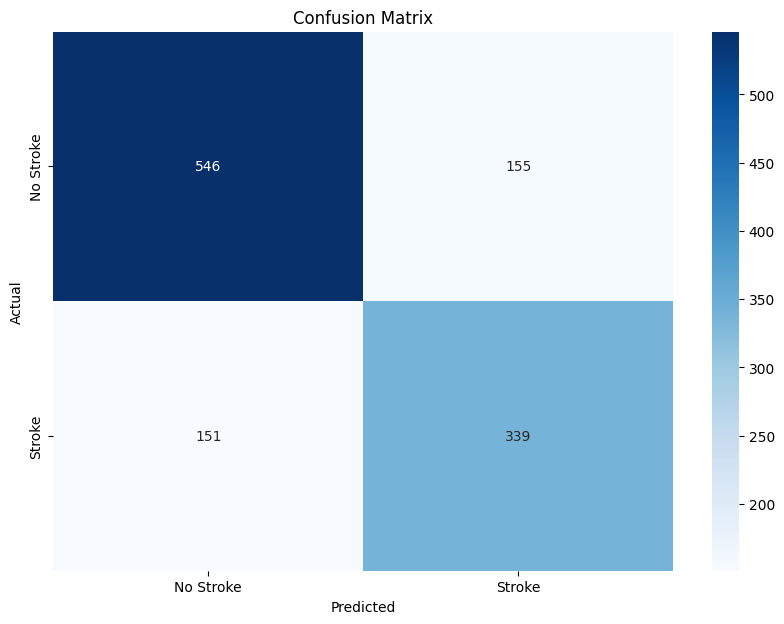

In [17]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Definisikan ruang pencarian untuk hyperparameter
search_spaces = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['linear']),
}

# Inisialisasi model SVM
svm_model = SVC(random_state=42)

# Inisialisasi BayesSearchCV
opt = BayesSearchCV(
    estimator=svm_model,
    search_spaces=search_spaces,
    n_iter=32,
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Lakukan pencarian hyperparameter dengan progress bar
with tqdm(total=32, desc="Bayesian Optimization Progress") as pbar:
    for i in range(32):
        opt.fit(X_train, y_train)
        pbar.update(1)

# Cetak hasil terbaik
print("Best parameters found: ", opt.best_params_)
print("Best cross-validation score: ", opt.best_score_)

# Gunakan model terbaik untuk prediksi
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report: \n", report)

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

results = []

# Loop through all combinations of folds dengan progress bar
with tqdm(total=25, desc="Training Progress") as pbar:
    for sf in range(1, 6):
        for nfs in range(1, 6):
            test_data, train_data = load_fold_data(sf, nfs)

            # Pisahkan fitur dan target untuk data train dan test
            X_train = train_data.drop(columns=['stroke'])
            y_train = train_data['stroke']
            X_test = test_data.drop(columns=['stroke'])
            y_test = test_data['stroke']

            # Inisialisasi model SVM
            svm_model = SVC(
                C=opt.best_params_['C'],
                gamma=opt.best_params_['gamma'],
                kernel=opt.best_params_['kernel'],
                random_state=42
            )

            # Latih model
            svm_model.fit(X_train, y_train)

            # Prediksi pada data test
            y_pred = svm_model.predict(X_test)

            # Evaluasi model
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            # Simpan hasil
            results.append({
                'Stroke Fold': sf,
                'Non-Stroke Fold': nfs,
                'Accuracy': accuracy,
                'Precision': report['weighted avg']['precision'],
                'Recall': report['weighted avg']['recall'],
                'F1-Score': report['weighted avg']['f1-score']
            })
            pbar.update(1)

# Buat DataFrame dari hasil
results_df = pd.DataFrame(results)

# Tampilkan hasil
print(results_df)
print(results_df.mean())

Training Progress: 100%|██████████| 25/25 [00:01<00:00, 23.34it/s]

    Stroke Fold  Non-Stroke Fold  Accuracy  Precision    Recall  F1-Score
0             1                1  0.679799   0.681761  0.679799  0.658474
1             1                2  0.752309   0.750332  0.752309  0.749126
2             1                3  0.653233   0.652096  0.653233  0.624286
3             1                4  0.683459   0.684361  0.683459  0.664444
4             1                5  0.738035   0.735920  0.738035  0.736208
5             2                1  0.768650   0.768795  0.768650  0.768721
6             2                2  0.752309   0.750557  0.752309  0.750841
7             2                3  0.738875   0.737478  0.738875  0.737943
8             2                4  0.738875   0.737818  0.738875  0.738228
9             2                5  0.740554   0.742514  0.740554  0.741303
10            3                1  0.725063   0.723822  0.725063  0.717332
11            3                2  0.720403   0.717425  0.720403  0.715603
12            3                3  0.69

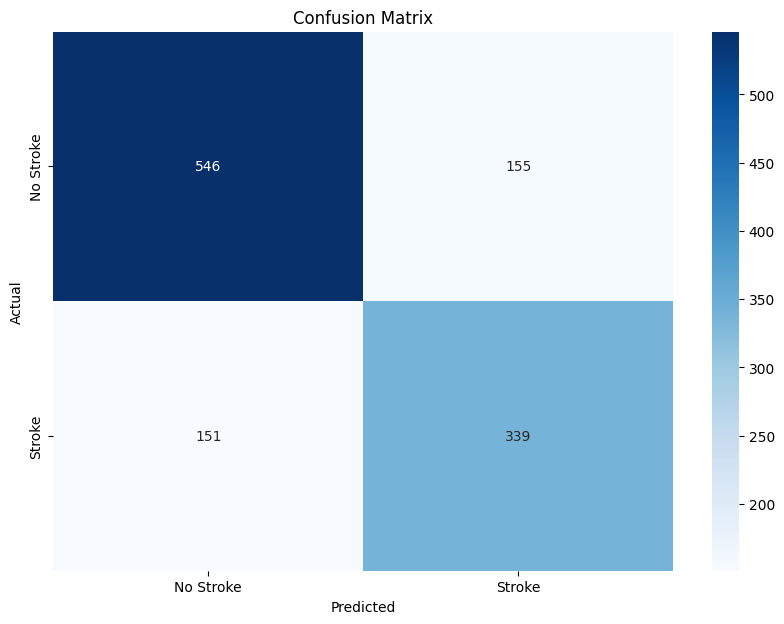

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()